## Graph Analysis of Orgchart Data

Simple example of an analysis over reporting data for employee level and span of control.

In [104]:
%matplotlib inline

import random
from collections import namedtuple, Counter

import networkx as nx
import matplotlib.pyplot as plt

GraphData = namedtuple('GraphData', ['nodes', 'edges'])

### Creating the Graph

For simplicity we generate a random (direct acyclic) graph that roughly mirrors a real reporting structure.
To instantiate such a graph from a given data only node data has to be provided, in many cases likely with additional "payload" data (name, etc.)

In [216]:
def generate_dag(last_id=0, parent_node=0, max_levels=5, span=(5, 10), leaf_prob=0.05):
    """ 
    generate demo data of a directed acyclic graph
    
    parameters:
    last_id - highest node id used so far
    parent_node - current parent id
    max_levels - maximum graph depth
    span - (min, max) number of children
    leaf_prob - probability that a given node is a leaf node without children
    """
    if max_levels <= 0 or random.random() < leaf_prob:
        return GraphData(nodes=set(), edges=set())
    
    num_children = random.randint(*span)
    nodes = {last_id + 1 + r for r in range(num_children)}
    edges = {(parent_node, c) for c in nodes}
    for child in nodes:
        subgraph = generate_dag(last_id=max(nodes), parent_node=child, max_levels=max_levels-1)
        nodes = nodes | subgraph.nodes
        edges = edges | subgraph.edges
    
    return GraphData(nodes=nodes, edges=edges)


def create_graph():
    dag_data = generate_dag()

    G = nx.DiGraph(list(dag_data.edges))

    return G

random.seed(23)
G = create_graph()

print('nodes in graph:', len(G))

nodes in graph: 22677


### Rendering the Graph

The below function is reasonably useful for small graphs, but does not work well for bigger graphs as the above.
For large-scale graph visualization a library such as gephi would be better suited.

In [217]:
#nx.draw(G)
#plt.show()

### Calculate Graph Stats

For each node calculate span-of-control (out_degree), level from the "bottom" and level from the "top".

In [218]:
from networkx.algorithms.dag import dag_longest_path_length, descendants
from networkx.algorithms.shortest_paths.generic import shortest_path_length
import numpy as np
import pandas as pd
COLUMNS = ['span', 'level_bottom', 'level_top']
SpanLevel = namedtuple('SpanLevel', COLUMNS)

res = []
for node in G:
    span = G.out_degree(node)
    level_top = shortest_path_length(G, 0, node)
    
    desc = descendants(G, node).union({node})
    subgraph = G.subgraph(desc)
    level_bottom = max(0, dag_longest_path_length(subgraph))
    
    res.append(SpanLevel(span=span, level_bottom=level_bottom, level_top=level_top))
    
freq_levels_bottom = Counter(r[1] for r in res)
freq_levels_bottom.most_common()

[(0, 19646), (1, 2605), (2, 368), (3, 50), (4, 7), (5, 1)]

In [219]:
df = pd.DataFrame(data=res, columns=COLUMNS)
df.describe()

,span,level_bottom,level_top
count,22677.000000,22677.000000,22677.000000
mean,0.999956,0.155400,4.836530
std,2.620941,0.426063,0.435312
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000
50%,0.000000,0.000000,5.000000
75%,0.000000,0.000000,5.000000
max,10.000000,5.000000,5.000000


It is noteworthy that the vast majority of employees has level "0". In this context it may make sense to not show any "leaf" non-managing employees to prevent this very large group from dominating the below analysis.

In [220]:
res = [r for r in res if r.level_bottom > 0]
df = pd.DataFrame(data=res, columns=COLUMNS)
df.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,span,level_bottom,level_top
count,3031.000000,3031.000000,3031.000000
mean,7.481359,1.162653,3.837347
std,1.703878,0.432512,0.432512
min,5.000000,1.000000,0.000000
10%,5.000000,1.000000,3.000000
20%,6.000000,1.000000,4.000000
30%,6.000000,1.000000,4.000000
40%,7.000000,1.000000,4.000000
50%,7.000000,1.000000,4.000000
60%,8.000000,1.000000,4.000000


### Visualizing the Distribution

For the visualization we have chosen a hexplot that can display the position of a group as well as its frequency/intensity. Since both dimensions of span and level are discrete and have very few possible values, a normal scatter would hide all of the frequency information.

Another alternative would be a bubble chart as show below and commented out.

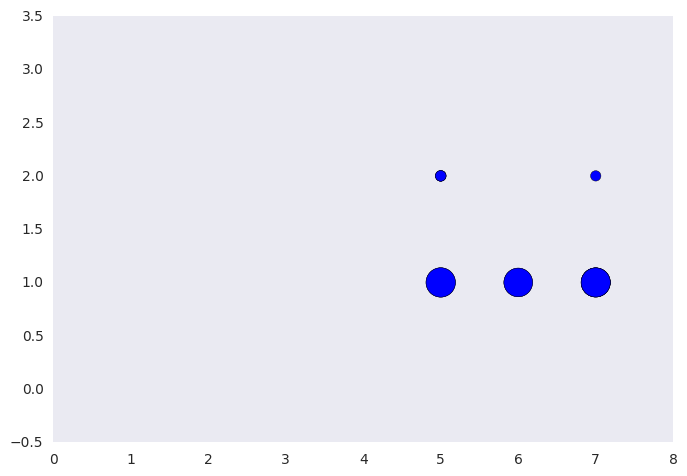

In [221]:
spans, levels = zip(*sls)
occurrences = Counter(tuple(r[:2]) for r in res)

plt.scatter(spans, levels, s=[occurrences[x] for x in sls])
plt.show()

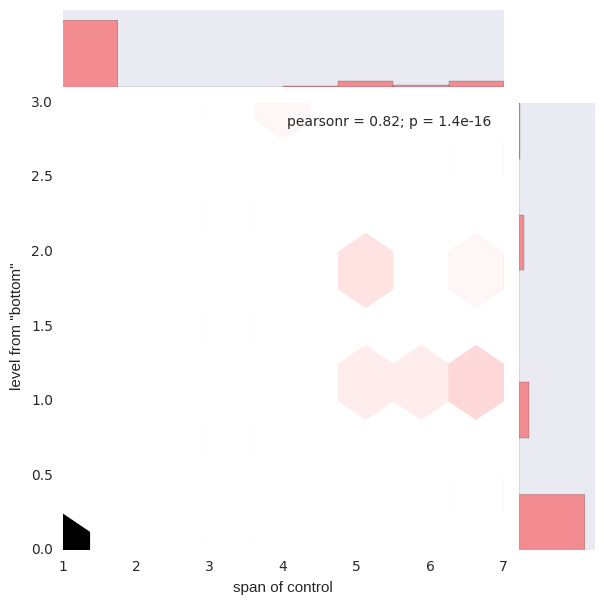

In [223]:
import seaborn as sns
sns.set_style('dark')


g = sns.jointplot(np.array(spans), np.array(levels), kind="hex", color='r')
g.set_axis_labels('span of control', 'level from "bottom"', fontsize=11)
plt.show()